# Predicting Car Accident Severity in Seattle

In this notebook, I analyzed the accident rates in the city of Seattle, from 2004 to 2019. Some of the points of interest were: accident rate per year, per day of the week and per month; what type of collision, weather, road condition, and light condition were most frequent during accidents and how the influence of drugs and alcohol impact the accidents' severity. 

After that, I created two machine learning algorithms to predict the car accident severity. 

The intent of this analysis is to provide authorities responsible for assisting in these cases, such as police and medical services, a better understand of how severe an accident is before getting into the location.  

Let's begin with the imports.

In [1]:
import calendar

import pandas as pd # for analysis
import numpy as np # for analysis

#for plotting
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt

from IPython import display

# for dealing with unbalancement and modeling
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb

# for modeling 
from sklearn import metrics
from sklearn import model_selection
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import resample

* Now, I opened the dataframe, checked the shape and checked on duplicated rows.

In [2]:
data_original = pd.read_csv('../Seattle_Capstone/data/Data-Collisions.csv', low_memory=False)

with pd.option_context('display.max_columns', None):
    display.display(data_original.head())

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
# df shape
data_original.shape

(194673, 38)

In [4]:
# How many duplicated rows in this df?
data_original[data_original.duplicated()].shape

(0, 38)

* Next, I checked on the dataframe characteristics.

In [5]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   SEVERITYCODE    194673 non-null  int64  
 1   X               189339 non-null  float64
 2   Y               189339 non-null  float64
 3   OBJECTID        194673 non-null  int64  
 4   INCKEY          194673 non-null  int64  
 5   COLDETKEY       194673 non-null  int64  
 6   REPORTNO        194673 non-null  object 
 7   STATUS          194673 non-null  object 
 8   ADDRTYPE        192747 non-null  object 
 9   INTKEY          65070 non-null   float64
 10  LOCATION        191996 non-null  object 
 11  EXCEPTRSNCODE   84811 non-null   object 
 12  EXCEPTRSNDESC   5638 non-null    object 
 13  SEVERITYCODE.1  194673 non-null  int64  
 14  SEVERITYDESC    194673 non-null  object 
 15  COLLISIONTYPE   189769 non-null  object 
 16  PERSONCOUNT     194673 non-null  int64  
 17  PEDCOUNT  

## 1. Data Cleaning

* First thing I did, was to convert the columns names to lowercase. 

In [6]:
data_original.columns = data_original.columns.str.lower()

* Next, I selected variables of interest to analyze.

In [7]:
atributes = data_original[['severitycode', 'addrtype', 'collisiontype', 'personcount', 
                           'pedcount', 'pedcylcount', 'vehcount', 'incdttm', 'weather', 
                           'lightcond', 'roadcond', 'st_colcode', 'underinfl']].copy()

In [8]:
# shape of new dataset
atributes.shape

(194673, 13)

In [9]:
# Checking on the target variable
atributes.severitycode.value_counts()

1    136485
2     58188
Name: severitycode, dtype: int64

In [10]:
# How many unique types does each categorical column have?
atributes.select_dtypes('object').nunique().to_frame()

,0
addrtype,3
collisiontype,10
incdttm,162058
weather,11
lightcond,9
roadcond,9
st_colcode,63
underinfl,4


* Let's evaluate the classes for the columns with 11 categories maximum.

In [11]:
categorical_cols = [col
                    for col in atributes.select_dtypes('object')
                    if atributes[col].nunique() <= 11]

for col in categorical_cols:
    print(col.upper())
    print('----')
    print(atributes[col].value_counts(dropna=False))
    print('-----------------------------')

ADDRTYPE
----
Block           126926
Intersection     65070
NaN               1926
Alley              751
Name: addrtype, dtype: int64
-----------------------------
COLLISIONTYPE
----
Parked Car    47987
Angles        34674
Rear Ended    34090
Other         23703
Sideswipe     18609
Left Turn     13703
Pedestrian     6608
Cycles         5415
NaN            4904
Right Turn     2956
Head On        2024
Name: collisiontype, dtype: int64
-----------------------------
WEATHER
----
Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
NaN                           5081
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: weather, dtype: int64
-----------------------------
LIGHTCOND
----
Daylight                  

* Some of the columns needed to be fixed.

In [12]:
# Fixing classes from some variables
## Correcting mistakes from data entries 
atributes.underinfl.replace({'0': 'N', '1': 'Y'}, inplace=True)
atributes.st_colcode.replace({' ': np.nan}, inplace=True)
atributes.severitycode.replace({1: 0, 2: 1}, inplace=True)

for col in categorical_cols[2:-1]:
    atributes[col].replace({'Unknown': np.nan}, inplace=True)
    
    
## Converting low frequencies classes into 'Other' class 
weather_to_change = ['Snowing', 'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 
                     'Blowing Sand/Dirt', 'Severe Crosswind', 'Partly Cloudy']
atributes.weather = atributes.weather.apply(lambda x: 'Other' if x in weather_to_change else x)


lightcond_to_change = ['Dark - No Street Lights', 'Dusk', 'Dawn', 
                       'Dark - Street Lights Off', 'Dark - Unknown Lighting']
atributes.lightcond = atributes.lightcond.apply(lambda x: 'Other' if x in lightcond_to_change else x)


roadcond_to_change = ['Snow/Slush', 'Ice', 'Sand/Mud/Dirt', 'Standing Water', 'Oil']
atributes.roadcond = atributes.roadcond.apply(lambda x: 'Other' if x in roadcond_to_change else x)

#### Addressing missing values

* First, I count how many missing values there were in each column.

In [13]:
atributes.isnull().sum()

severitycode         0
addrtype          1926
collisiontype     4904
personcount          0
pedcount             0
pedcylcount          0
vehcount             0
incdttm              0
weather          20172
lightcond        18643
roadcond         20090
st_colcode        4904
underinfl         4884
dtype: int64

* Is hard to find what was the code of each accident, so I removed rows where `st_colcode` was missing.

In [14]:
# Removing rows where st_colcode is missing. 
atributes = atributes[(atributes.st_colcode.isnull() == False)].copy()
atributes.reset_index(drop=True, inplace=True)

* On the rest of the columns, I filled the missing values with the mode.

In [15]:
cols_to_fillna = ['addrtype', 'weather', 'lightcond', 'roadcond', 'underinfl']

for col in cols_to_fillna:
    mode = atributes[col].mode()
    atributes[col] = atributes[col].fillna(mode[0]) 

In [16]:
# checking if there was any missing value left
atributes.isnull().sum()

severitycode     0
addrtype         0
collisiontype    0
personcount      0
pedcount         0
pedcylcount      0
vehcount         0
incdttm          0
weather          0
lightcond        0
roadcond         0
st_colcode       0
underinfl        0
dtype: int64

#### Fixing dtypes

In [17]:
# Converting categorical to numerical
dict_cols = {}
cols_to_convert = ['addrtype', 'underinfl']

for col in cols_to_convert:
    atributes[col] = atributes[col].astype('category')
    
    # The encodding will be saved in a dictionary
    dict_cols[col] = dict(enumerate(atributes.loc[:, col].cat.categories))
    dict_cols[col] = {v: k for k, v in dict_cols[col].items()} # reverting key/value
    
    atributes[col] = atributes[col].map(dict_cols[col]).astype('int')  

In [18]:
# Fixing columns types
atributes.st_colcode = atributes.st_colcode.astype('int')
atributes.incdttm = pd.to_datetime(atributes.incdttm)

* I created dummies for the column with too many categories.

In [19]:
cols_object = atributes.select_dtypes('object').columns.values.tolist()

atributes_dummies = pd.get_dummies(data=atributes, 
                         columns=cols_object, 
                         prefix=['ct', 'w', 'lc', 'rc'])

In [20]:
# checking if all the columns had their types corrected
atributes.dtypes

severitycode              int64
addrtype                  int64
collisiontype            object
personcount               int64
pedcount                  int64
pedcylcount               int64
vehcount                  int64
incdttm          datetime64[ns]
weather                  object
lightcond                object
roadcond                 object
st_colcode                int64
underinfl                 int64
dtype: object

* All the columns had their entries and types corrected.

## 2. Data Analysis 

* I started the analysis creating a new dataframe without 2020 accidents, since the year is still not over.

In [21]:
# special dataframe 
datetime_filter = ~(atributes['incdttm'].dt.year == 2020)
atributes_without_2020 = atributes[datetime_filter].copy()

* Checking the accident rate per days of the week.

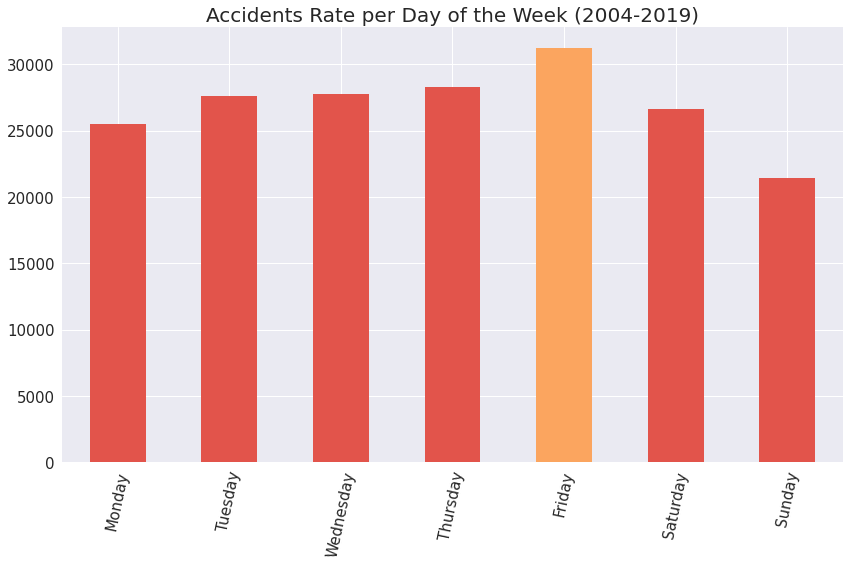

In [22]:
plt.style.use('seaborn')
sns.set_palette('Spectral')

colors = ['#FBA55F' if i == 4 else '#E2544B' for i in range(7)]

atributes_without_2020['incdttm'].dt.weekday\
                    .value_counts(sort=False)\
                    .plot(kind='bar', figsize=(14,8), color=colors)

labels = [calendar.day_name[i] for i in range(7)]
positions = [i for i in range(7)]
plt.title('Accidents Rate per Day of the Week (2004-2019)', fontsize=20)
plt.xticks(positions, 
           labels, 
           rotation=78, 
           fontsize=15)
plt.yticks(fontsize=15)
plt.show()

* Checking the accident rate per months.

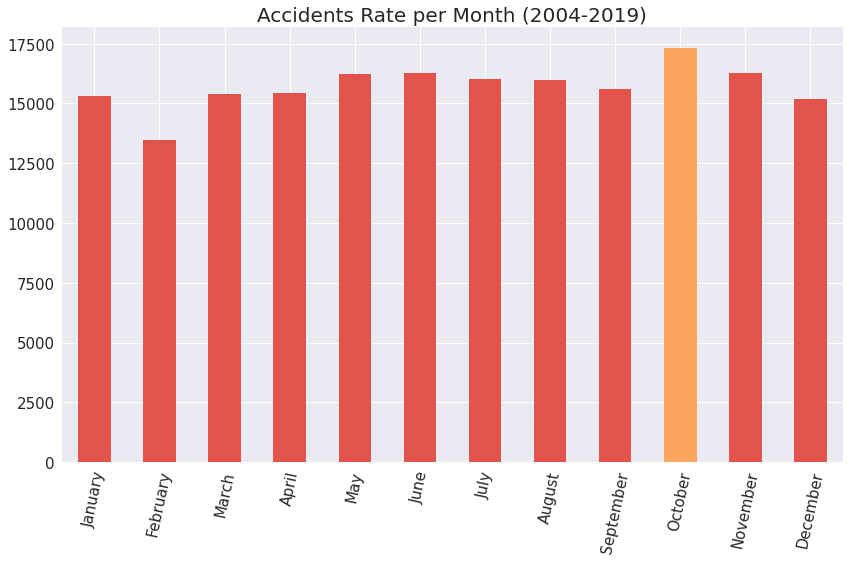

In [23]:
colors = ['#FBA55F' if i == 9 else '#E2544B' for i in range(12)]

atributes_without_2020['incdttm'].dt.month\
                    .value_counts(sort=False)\
                    .plot(kind='bar', figsize=(14,8), color=colors)

labels = [calendar.month_name[i] for i in range(1,13)]
positions = [i for i in range(12)]
plt.title('Accidents Rate per Month (2004-2019)', fontsize=20)
plt.xticks(positions, 
           labels, 
           rotation=78, 
           fontsize=15)
plt.yticks(fontsize=15)
plt.show()

* Checking the accident rate over the years.

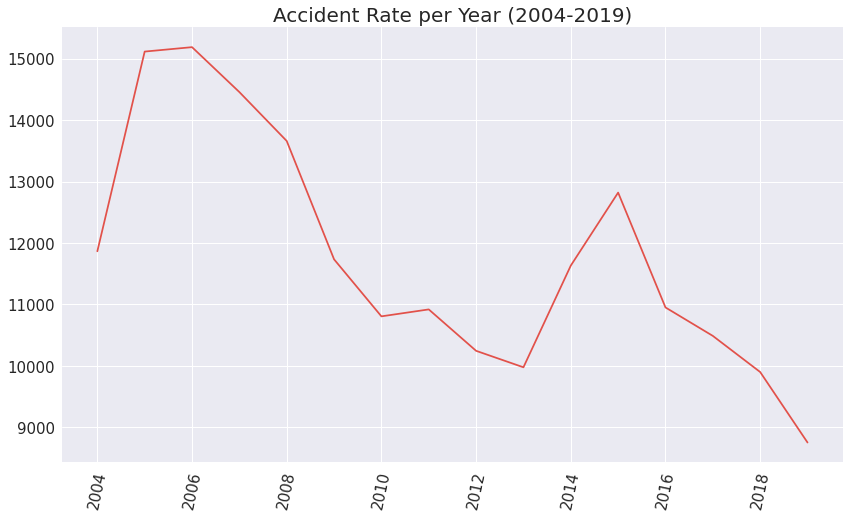

In [24]:
atributes_without_2020['incdttm'].dt.year\
                    .value_counts(sort=False)\
                    .plot(kind='line', figsize=(14,8))
plt.title('Accident Rate per Year (2004-2019)', fontsize=20)
plt.xticks(rotation=78, fontsize=15)
plt.yticks(fontsize=15)
plt.show()

* Checking the most common causes of accidents.

In [25]:
# What proportion of all accidents the common causes represent?
ratio = atributes_without_2020.st_colcode.value_counts().nlargest(10).sum()/len(atributes_without_2020)

print(f'These state collision codes represent {ratio.round(4) * 100}% of all accidents causes.')

These state collision codes represent 85.11% of all accidents causes.


In [26]:
# How do these common causes correlate to the severity code?
stcode_severity = pd.crosstab(atributes_without_2020.st_colcode, 
                              atributes_without_2020.severitycode) 
                           
stcode_top_10 = atributes_without_2020.st_colcode.value_counts()\
                                               .nlargest(10)\
                                               .index.tolist()

top_10_crosstab = stcode_severity[stcode_severity.index.isin(stcode_top_10)].copy()
top_10_crosstab['sum'] = top_10_crosstab[[0,1]].sum(axis=1)
top_10_crosstab.sort_values('sum', inplace=True, ascending=False)
top_10_crosstab.drop('sum', axis=1, inplace=True)
top_10_crosstab

severitycode,0,1
st_colcode,,
32,42080,2124
10,20857,13513
14,14317,11318
50,10178,3259
11,10938,1747
28,5655,4596
13,4533,3042
45,579,4122
23,3669,835


In [27]:
# In case 45, how much of the accidents are severity 1?
4122 / (579 + 4122)

0.8768347160178686

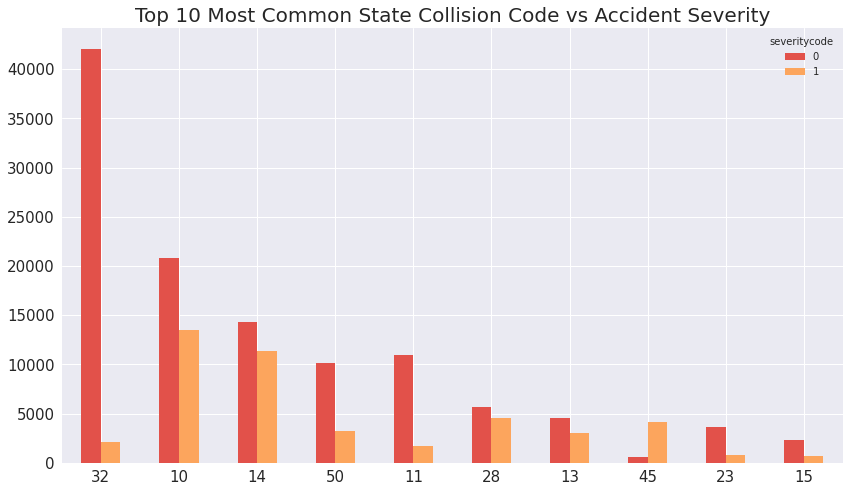

In [28]:
# Plotting the relation
sns.set_palette('Spectral')
top_10_crosstab.plot(kind='bar', figsize=(14,8))

plt.title('Top 10 Most Common State Collision Code vs Accident Severity', 
          fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

In [29]:
# Dict with the correlation of code and cause
st_code_dict = {'32': 'One Parked/One Moving',
               '10': 'Entering At Angle',
               '14': 'From Same Direction/Both Going Straight/One Stopped/Rear End',
               '50': 'Struck Fixed Object',
               '11': 'From Same Direction/Both Going Straight/Both Moving/Sideswipe',
               '28': 'From Opposite Direction/One Left Turn/One Straight', 
               '13': 'From Same Direction/Both Going Straight/Both Moving/Rear End',
               '45': 'Bicycle',
               '23': 'From Same Direction/All Others',
               '15': 'From Same Direction/One Left Turn/One Straight'}

st_code_dict['28']

'From Opposite Direction/One Left Turn/One Straight'

* Checking on the collision address type.

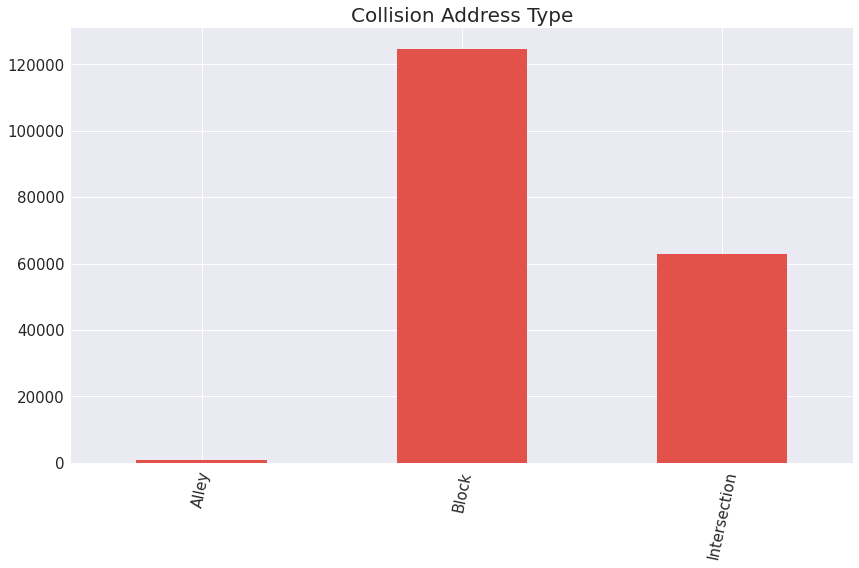

In [30]:
atributes_without_2020['addrtype'].value_counts(sort=False)\
                                  .plot(kind='bar', figsize=(14,8))

plt.title('Collision Address Type', fontsize=20)
plt.xticks([*dict_cols['addrtype'].values()],
           [*dict_cols['addrtype'].keys()],
           rotation=78, 
           fontsize=15)
plt.yticks(fontsize=15)
plt.show()

* Checking on the impact of weather, road condition and light condition on the accidents severity.

In [31]:
def get_ratio(col, value, df=atributes_without_2020):
    """Calculates the proportion of a class in a whole dataset."""
    ratio = df[col].eq(value).sum() / len(df) * 100
    return ratio.round()

In [32]:
# getting the ratio for the most common weather, road condition and light condition 
weather_ratio = get_ratio('weather', 'Clear')
roadcond_ratio = get_ratio('roadcond', 'Dry')
lightcond_ratio = get_ratio('lightcond', 'Daylight')

print(f'{weather_ratio}% of all accidents occurred with clear weather.')
print(f'{roadcond_ratio}% of all accidents occurred with dry road.')
print(f'{lightcond_ratio}% of all accidents occurred during daylight.')

67.0% of all accidents occurred with clear weather.
74.0% of all accidents occurred with dry road.
68.0% of all accidents occurred during daylight.


> * Weather

In [33]:
pd.crosstab(atributes_without_2020['severitycode'], atributes_without_2020['weather'], normalize='index')*100

weather,Clear,Other,Overcast,Raining
severitycode,,,,
0,67.784853,1.471604,14.246249,16.497294
1,64.354063,0.902250,15.244859,19.498828


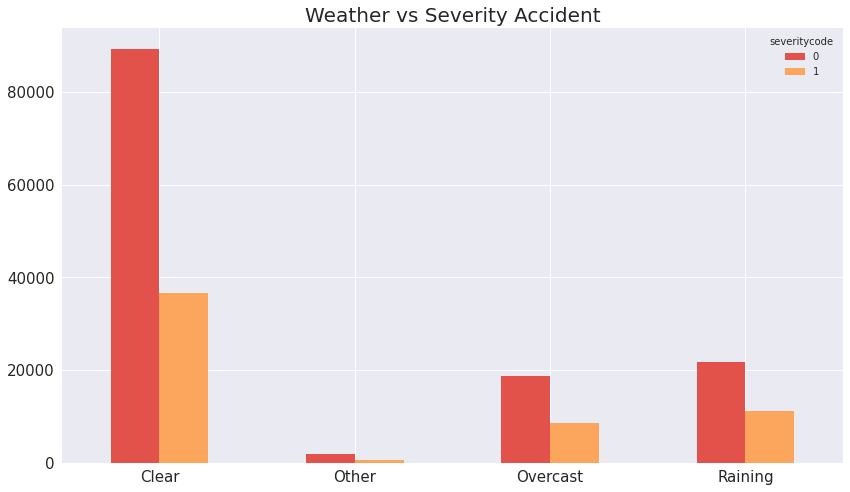

In [34]:
sns.set_palette('Spectral')

pd.crosstab(atributes_without_2020['weather'], atributes_without_2020['severitycode'])\
               .plot(kind='bar', figsize=(14,8))
plt.title('Weather vs Severity Accident', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

> * Road Conditions

In [35]:
pd.crosstab(atributes_without_2020['severitycode'], atributes_without_2020['roadcond'], normalize='index')*100

roadcond,Dry,Other,Wet
severitycode,,,
0,74.668529,1.533079,23.798393
1,71.565017,0.979787,27.455196


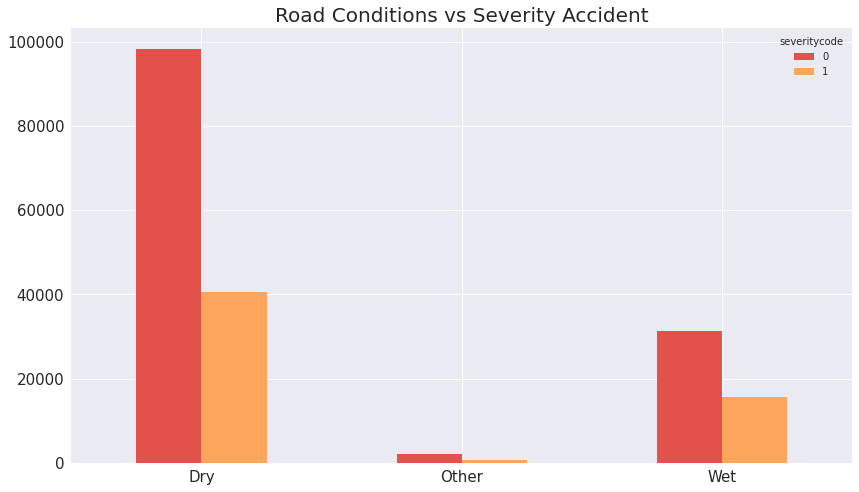

In [36]:
sns.set_palette('Spectral')

pd.crosstab(atributes_without_2020['roadcond'], atributes_without_2020['severitycode'])\
               .plot(kind='bar', figsize=(14,8))
plt.title('Road Conditions vs Severity Accident', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

> * Light Conditions

In [37]:
pd.crosstab(atributes_without_2020['severitycode'], atributes_without_2020['lightcond'], normalize='index')*100

lightcond,Dark - Street Lights On,Daylight,Other
severitycode,,,
0,25.619113,68.426925,5.953962
1,25.278869,68.657374,6.063757


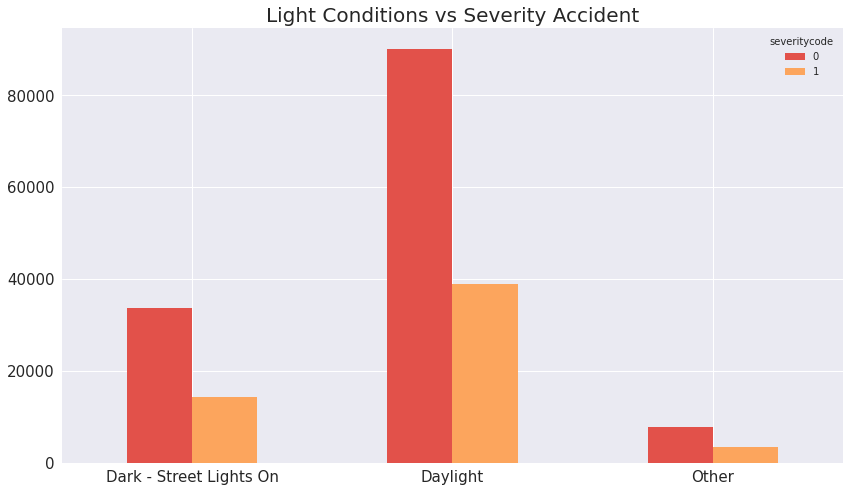

In [38]:
sns.set_palette('Spectral')

pd.crosstab(atributes_without_2020['lightcond'], atributes_without_2020['severitycode'])\
               .plot(kind='bar', figsize=(14,8))
plt.title('Light Conditions vs Severity Accident', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

In [39]:
pd.crosstab(atributes_without_2020['severitycode'], atributes_without_2020['collisiontype'], normalize='index')*100

collisiontype,Angles,Cycles,Head On,Left Turn,Other,Parked Car,Pedestrian,Rear Ended,Right Turn,Sideswipe
severitycode,,,,,,,,,,
0,15.829418,0.507737,0.865203,6.252988,13.259614,34.236231,0.502425,14.638626,1.772148,12.135609
1,23.812713,8.305285,1.524310,9.466580,10.693076,4.646942,10.375879,25.738806,1.060849,4.375562


In [40]:
def maxlabel(rects, n=1):
    """Attach a text label above n tallest bars in rects, displaying its height."""
    heights = np.empty(len(rects))
    for i, rect in enumerate(rects):
        heights[i] = rect.get_height()

    maxes = []
    idx = np.argsort(heights)
    for i in range(1, n + 1):
        maxes.append(idx[-i])

    for m in (maxes):
        rect = rects[m]
        ax.annotate('{:.1f}'.format(heights[m]),
                    xy=(rect.get_x() + rect.get_width() / 2, heights[m]),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)

* Measuring the impact of the collision type on the accident severity.

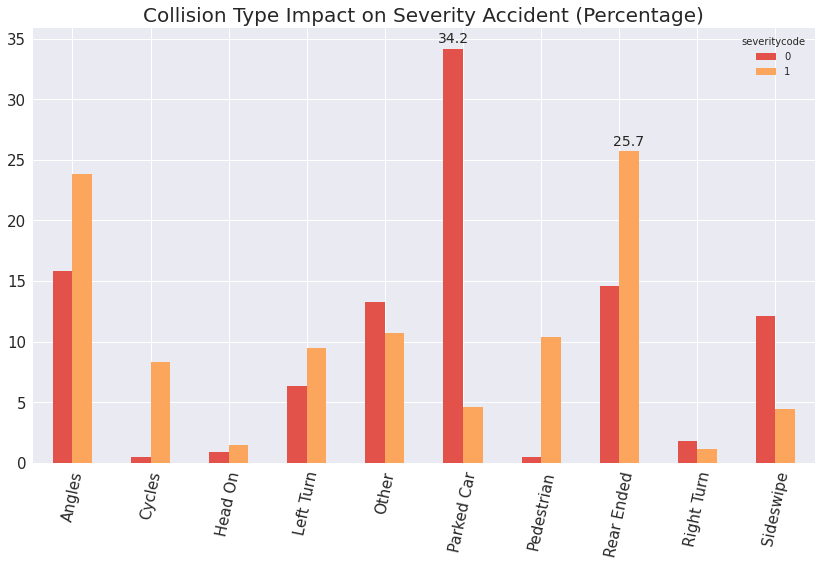

In [41]:
sns.set_palette('Spectral')

ax = pd.crosstab(atributes_without_2020['collisiontype'], atributes_without_2020['severitycode'])\
               .apply(lambda r: r/r.sum()*100, axis=0)\
               .round(1)\
               .plot(kind='bar', figsize=(14,8))
plt.title('Collision Type Impact on Severity Accident (Percentage)', fontsize=20)
plt.xticks(rotation=78, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
bars = ax.patches
maxlabel(bars, 2)
    
plt.show()

* Measuring the impact of the influence of drugs and alcohol on the accident severity.

In [42]:
pd.crosstab(atributes_without_2020['severitycode'], atributes_without_2020['underinfl'], normalize='columns')*100

underinfl,0,1
severitycode,,
0,70.351974,60.942982
1,29.648026,39.057018


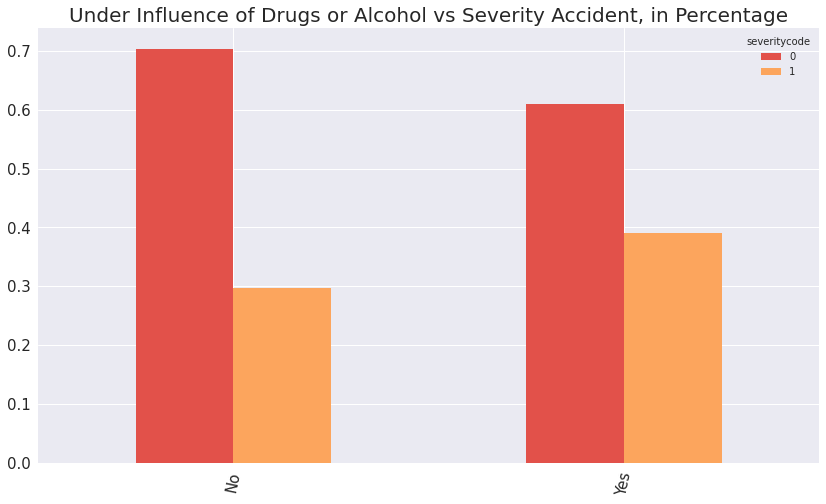

In [43]:
sns.set_palette('Spectral')

ax = pd.crosstab(atributes_without_2020['underinfl'], atributes_without_2020['severitycode'], normalize='index')\
               .plot(kind='bar', figsize=(14,8))
plt.title('Under Influence of Drugs or Alcohol vs Severity Accident, in Percentage', fontsize=20)
plt.xticks([*dict_cols['underinfl'].values()],
           ['No', 'Yes'],
           rotation=78, 
           fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.show()

* Checking on how many people and cars, on average, get involved in accidents.

In [44]:
atributes_without_2020[['vehcount', 'personcount', 'severitycode']].groupby('severitycode')\
                                                                   .describe().T

severitycode                   0             1
vehcount    count  131761.000000  56747.000000
            mean        1.999810      1.902250
            std         0.473709      0.710585
            min         0.000000      0.000000
            25%         2.000000      2.000000
            50%         2.000000      2.000000
            75%         2.000000      2.000000
            max        12.000000     11.000000
personcount count  131761.000000  56747.000000
            mean        2.343023      2.728003
            std         1.243085      1.554657
            min         0.000000      0.000000
            25%         2.000000      2.000000
            50%         2.000000      2.000000
            75%         3.000000      3.000000
            max        57.000000     81.000000

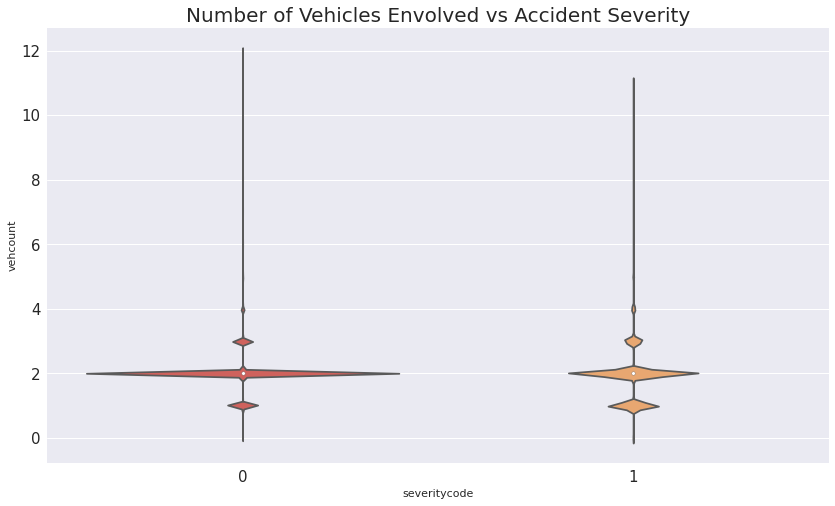

In [45]:
# Vehicles
sns.color_palette('Spectral')
plt.figure(figsize=(14,8))
sns.violinplot(data=atributes_without_2020, x='severitycode', y='vehcount')
plt.title('Number of Vehicles Envolved vs Accident Severity', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

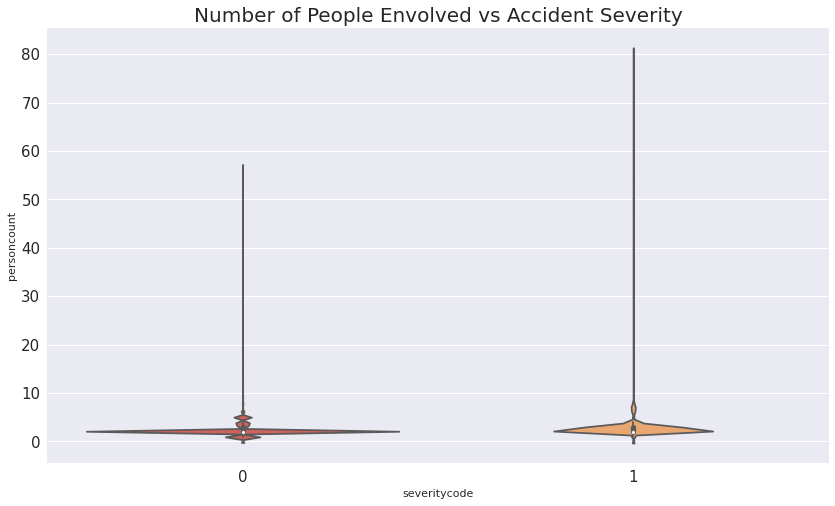

In [46]:
# People
sns.color_palette('Spectral')
plt.figure(figsize=(14,8))
sns.violinplot(data=atributes_without_2020, x='severitycode', y='personcount')
plt.title('Number of People Envolved vs Accident Severity', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

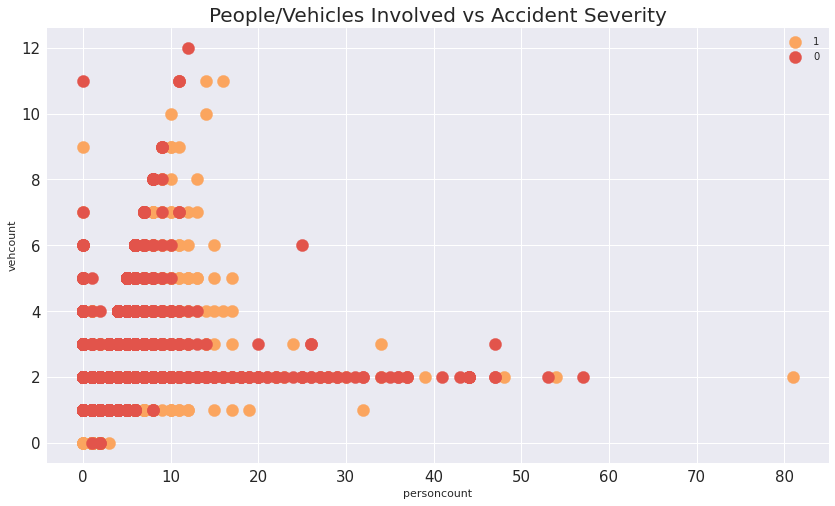

In [47]:
# People and cars involved vs accident severity
ax1 = atributes_without_2020[atributes_without_2020.severitycode.eq(1)].plot(kind='scatter', 
                                                   x='personcount', 
                                                   y='vehcount',
                                                   s=150,
                                                   color='#FBA55F', 
                                                   label='1',
                                                   figsize=(14,8))
atributes_without_2020[atributes_without_2020.severitycode.eq(0)].plot(kind='scatter', 
                                             x='personcount', 
                                             y='vehcount',
                                             s=150,
                                             color='#E2544B', 
                                             label='0',
                                             figsize=(14,8), 
                                             ax=ax1)

plt.title('People/Vehicles Involved vs Accident Severity', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## 3. Feature selection and Preprocessing

* After analysis, it's time to select predictors for the models. The first thing I did was to remove near-zero variance variables.

In [48]:
atributes_to_array = atributes_dummies[datetime_filter].drop(['incdttm'], axis=1).copy()

sel = VarianceThreshold(threshold=(.9 * (1 - .9)))
final_set = sel.fit_transform(np.array(atributes_to_array))
final_set = atributes_to_array.loc[:, sel.get_support()]
final_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188508 entries, 0 to 189768
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   severitycode                188508 non-null  int64
 1   addrtype                    188508 non-null  int64
 2   personcount                 188508 non-null  int64
 3   vehcount                    188508 non-null  int64
 4   st_colcode                  188508 non-null  int64
 5   ct_Angles                   188508 non-null  uint8
 6   ct_Other                    188508 non-null  uint8
 7   ct_Parked Car               188508 non-null  uint8
 8   ct_Rear Ended               188508 non-null  uint8
 9   w_Clear                     188508 non-null  uint8
 10  w_Overcast                  188508 non-null  uint8
 11  w_Raining                   188508 non-null  uint8
 12  lc_Dark - Street Lights On  188508 non-null  uint8
 13  lc_Daylight                 188508 non-null 

* The remaining variables were the predictors for the models. 

  Next, I split the dataset into a training and a testing set. I stratified the sets because of the target variable imbalance.

In [49]:
y = final_set['severitycode']
X = final_set.drop('severitycode', axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.3,
                                                                    stratify=y,
                                                                    random_state=12)

In [50]:
y_train.value_counts()

0    92232
1    39723
Name: severitycode, dtype: int64

* For the Lasso regression, I normalized the data.

In [51]:
norm = MinMaxScaler().fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

## 4. Modeling 

### **Lasso Regression**

#### Pipelines

I created a model without resampling and a model with resampling.

In [52]:
# Imbalanced Lasso
lasso_pipe = make_pipeline(LogisticRegression(max_iter=1000, 
                                                penalty='l1', 
                                                solver='liblinear'))

# Balanced Lasso
lasso_pipe_balanced = make_pipeline_imb(RandomUnderSampler(random_state=12), 
                                        LogisticRegression(max_iter=1000, 
                                                             penalty='l1', 
                                                             solver='liblinear',
                                                             C=0.1))

##### **GridSearchCV**

I used the ``gridsearch`` to find the best parameters for the models.

#### Training and prediction

In [53]:
# Imbalanced Lasso
lasso_pipe.fit(X_train_norm, y_train)

# Balanced Lasso
lasso_pipe_balanced.fit(X_train_norm, y_train)

Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=12, replacement=False,
                                    sampling_strategy='auto')),
                ('logisticregression',
                 LogisticRegression(C=0.1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [54]:
# Imbalanced Lasso
imb_lasso_yhat = lasso_pipe.predict(X_test_norm)
imb_lasso_yhat_p = lasso_pipe.predict_proba(X_test_norm)

# Balanced Lasso
bal_lasso_yhat = lasso_pipe_balanced.predict(X_test_norm)
bal_lasso_yhat_p = lasso_pipe_balanced.predict_proba(X_test_norm)

#### Comparing results

**a. Classification metrics**

In [55]:
# Imbalanced Lasso
print('Classification Report (Lasso imbalanced):')
print(classification_report_imbalanced(y_test, imb_lasso_yhat))

# Balanced Lasso
print('\nClassification Report (Lasso balanced):')
print(classification_report_imbalanced(y_test, bal_lasso_yhat))

Classification Report (Lasso imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.74      0.94      0.23      0.83      0.46      0.23     39529
          1       0.61      0.23      0.94      0.33      0.46      0.20     17024

avg / total       0.70      0.72      0.44      0.68      0.46      0.22     56553


Classification Report (Lasso balanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.52      0.81      0.65      0.65      0.41     39529
          1       0.42      0.81      0.52      0.55      0.65      0.43     17024

avg / total       0.73      0.60      0.72      0.62      0.65      0.41     56553



**b. Confusion matrix**

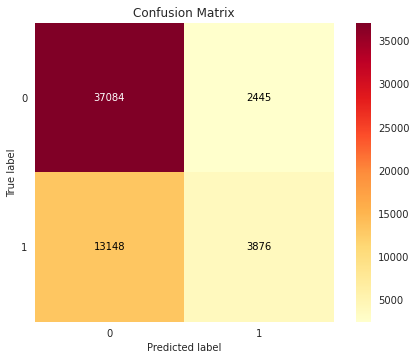

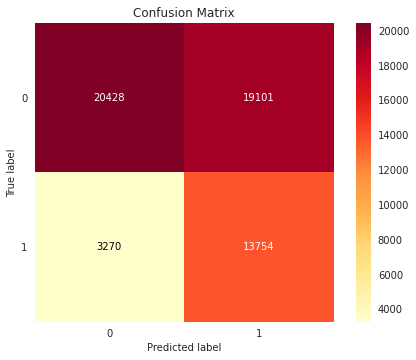

In [56]:
# Imbalanced Lasso
skplt.metrics.plot_confusion_matrix(y_test, 
                                    imb_lasso_yhat,
                                    cmap='YlOrRd')

# Balanced Lasso
skplt.metrics.plot_confusion_matrix(y_test, 
                                    bal_lasso_yhat,
                                    cmap='YlOrRd')

plt.show()

#### Feature importance

Feature: 0, Score: 0.99087
Feature: 1, Score: 17.26079
Feature: 2, Score: -5.07977
Feature: 3, Score: -0.33142
Feature: 4, Score: -0.14428
Feature: 5, Score: -0.42691
Feature: 6, Score: -1.96882
Feature: 7, Score: 0.42262
Feature: 8, Score: 0.03582
Feature: 9, Score: 0.02486
Feature: 10, Score: 0.04266
Feature: 11, Score: 0.00000
Feature: 12, Score: -0.06777
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000


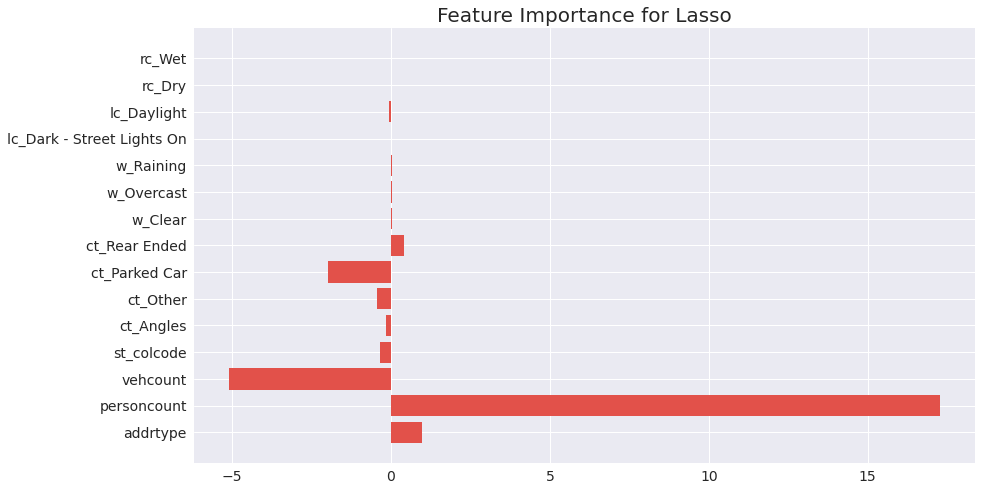

In [57]:
importance = lasso_pipe_balanced[1].coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(14,8))
plt.barh([x for x in X_train.columns.values.tolist()], importance)
plt.title('Feature Importance for Lasso', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### **Random Forests**

#### Pipelines

Once again, I created two models: without and with resampling.

In [58]:
# Imbalanced Random Forests
rf_pipe = make_pipeline(RandomForestClassifier(max_depth=6, 
                                               min_samples_leaf=10))

# Balanced Random Forests
rf_pipe_balanced = make_pipeline_imb(RandomUnderSampler(random_state=12),
                                     RandomForestClassifier(max_depth=6, 
                                                            min_samples_leaf=10))

##### **GridSearchCV**

Searched for the parameters, as well.

#### Training and prediction

In [59]:
# Imbalanced Random Forests
rf_pipe.fit(X_train, y_train)

# Balanced Random Forests
rf_pipe_balanced.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomundersampler',
                 RandomUnderSampler(random_state=12, replacement=False,
                                    sampling_strategy='auto')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=6, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_

In [60]:
# Random Forest desbalanceada
imb_rf_yhat = rf_pipe.predict(X_test)
imb_rf_yhat_p = rf_pipe.predict_proba(X_test)

# Random Forest balanceada
bal_rf_yhat = rf_pipe_balanced.predict(X_test)
bal_rf_yhat_p = rf_pipe_balanced.predict_proba(X_test)

#### Comparing results

**a. Classification metrics**

In [61]:
# Imbalanced Random Forests
print('Classification Report (RF imbalanced):')
print(classification_report_imbalanced(y_test, imb_rf_yhat))

# Balanced Random Forests
print('\nClassification Report (RF balanced):')
print(classification_report_imbalanced(y_test, bal_rf_yhat))

Classification Report (RF imbalanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.98      0.23      0.85      0.48      0.24     39529
          1       0.81      0.23      0.98      0.36      0.48      0.21     17024

avg / total       0.77      0.75      0.46      0.70      0.48      0.23     56553


Classification Report (RF balanced):
                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.60      0.82      0.71      0.70      0.48     39529
          1       0.47      0.82      0.60      0.59      0.70      0.50     17024

avg / total       0.76      0.67      0.75      0.68      0.70      0.49     56553



**b. Confusion matrix**

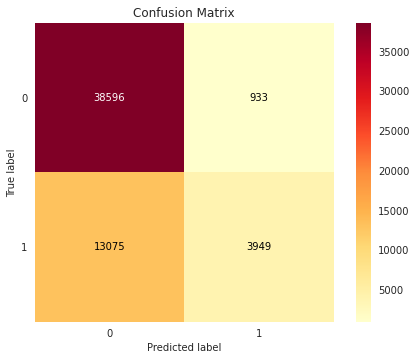

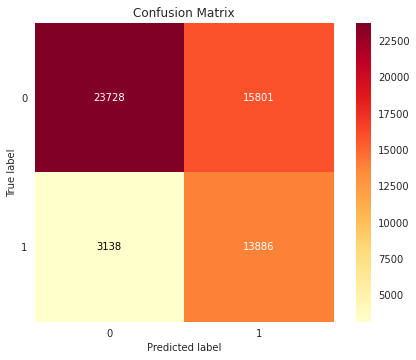

In [62]:
# Imbalanced Random Forests
skplt.metrics.plot_confusion_matrix(y_test, 
                                    imb_rf_yhat,
                                    cmap='YlOrRd')

# Balanced Random Forests
skplt.metrics.plot_confusion_matrix(y_test, 
                                    bal_rf_yhat,
                                    cmap='YlOrRd')

plt.show()

#### Feature importance

Feature: 0, Score: 0.07890
Feature: 1, Score: 0.07866
Feature: 2, Score: 0.15834
Feature: 3, Score: 0.26256
Feature: 4, Score: 0.01454
Feature: 5, Score: 0.03864
Feature: 6, Score: 0.30791
Feature: 7, Score: 0.05181
Feature: 8, Score: 0.00084
Feature: 9, Score: 0.00040
Feature: 10, Score: 0.00134
Feature: 11, Score: 0.00182
Feature: 12, Score: 0.00193
Feature: 13, Score: 0.00115
Feature: 14, Score: 0.00116


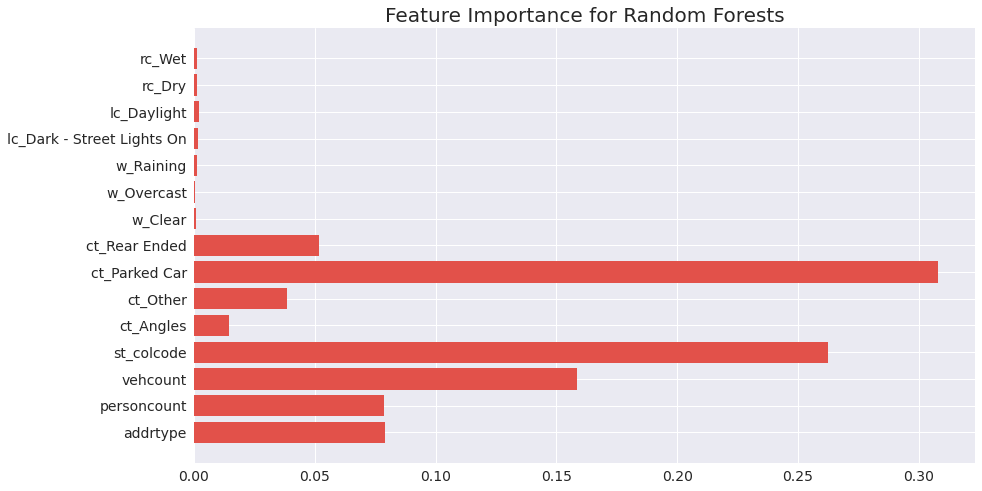

In [63]:
importance = rf_pipe_balanced[1].feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize=(14,8))
plt.barh([x for x in X_train.columns.values.tolist()], importance)
plt.title('Feature Importance for Random Forests', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## 5. Models comparison (Lasso vs Random Forests)

### ROC Curve

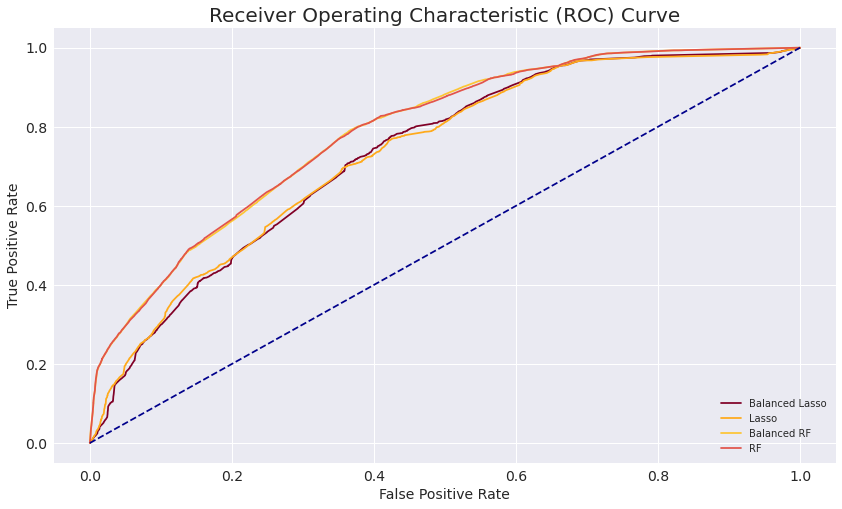

In [64]:
## Lasso
fper_lasso, tper_lasso, thresholds = metrics.roc_curve(y_test, bal_lasso_yhat_p[:,1])
fper_lasso_im, tper_lasso_im, thresholds = metrics.roc_curve(y_test, imb_lasso_yhat_p[:,1])

## Random Forests
fper_rf, tper_rf, thresholds = metrics.roc_curve(y_test, bal_rf_yhat_p[:,1])
fper_rf_im, tper_rf_im, thresholds = metrics.roc_curve(y_test, imb_rf_yhat_p[:,1])


plt.style.use('seaborn')
plt.figure(figsize=(14,8))

plt.plot(fper_lasso, tper_lasso, label='ROC', color='#800026')
plt.plot(fper_lasso_im, tper_lasso_im, label='ROC', color='#FFAA1B')

plt.plot(fper_rf, tper_rf, label='ROC', color='#FDC534')
plt.plot(fper_rf_im, tper_rf_im, label='ROC', color='#E2544B')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
plt.legend(['Balanced Lasso', 'Lasso', 'Balanced RF', 'RF'], loc='lower right')
plt.show()

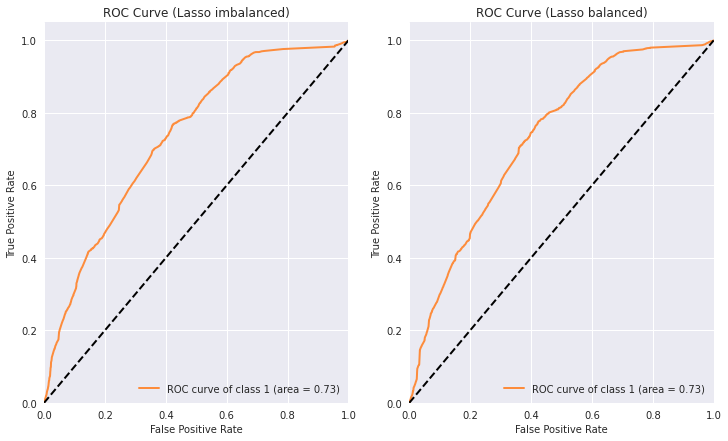

In [65]:
# Lasso
fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

skplt.metrics.plot_roc(y_test, 
                       imb_lasso_yhat_p, 
                       plot_micro=False, 
                       plot_macro=False, 
                       classes_to_plot=[1],
                       title='ROC Curve (Lasso imbalanced)', 
                       cmap='YlOrRd',
                       ax=ax0)


skplt.metrics.plot_roc(y_test, 
                       bal_lasso_yhat_p, 
                       plot_micro=False, 
                       plot_macro=False, 
                       classes_to_plot=[1],
                       title='ROC Curve (Lasso balanced)',
                       cmap='YlOrRd',
                       ax=ax1)

plt.show()

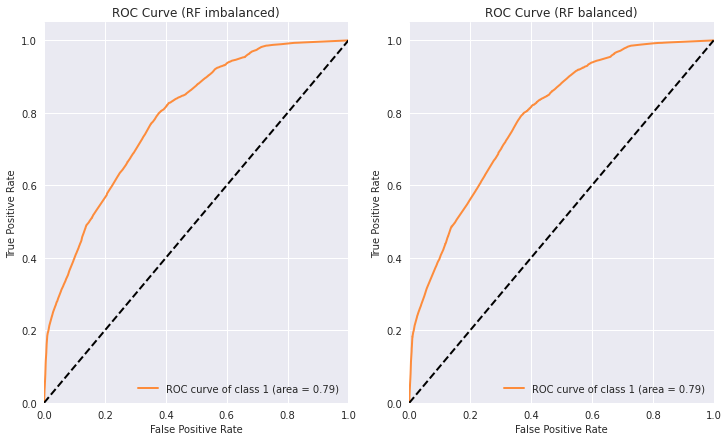

In [66]:
# RF
fig = plt.figure(figsize=(12,7))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)


skplt.metrics.plot_roc(y_test, 
                       imb_rf_yhat_p, 
                       plot_micro=False, 
                       plot_macro=False, 
                       classes_to_plot=[1],
                       title='ROC Curve (RF imbalanced)',
                       cmap='YlOrRd',
                       ax=ax0)


skplt.metrics.plot_roc(y_test, 
                       bal_rf_yhat_p, 
                       plot_micro=False, 
                       plot_macro=False, 
                       classes_to_plot=[1],
                       title='ROC Curve (RF balanced)',
                       cmap='YlOrRd',
                       ax=ax1)

plt.show()

### Calibrating the models

In [67]:
# Fit a model with calibration
## Lasso
lasso_calibrated = CalibratedClassifierCV(lasso_pipe_balanced, cv=5, method='sigmoid')
lasso_calibrated.fit(X_train, y_train)

## Random Forest
rf_calibrated = CalibratedClassifierCV(rf_pipe_balanced, cv=5, method='sigmoid')
rf_calibrated.fit(X_train, y_train)

# Get values from calibration
## Lasso
lasso_fop, lasso_mpv = calibration_curve(y_test, bal_lasso_yhat_p[:, 1], normalize=True, n_bins=10)
lasso_fop_bal, lasso_mpv_bal = calibration_curve(y_test, lasso_calibrated.predict_proba(X_test_norm)[:, 1], n_bins=10, normalize=True)

## Random Forest
rf_fop, rf_mpv = calibration_curve(y_test, bal_rf_yhat_p[:, 1], normalize=True, n_bins=10)
rf_fop_bal, rf_mpv_bal = calibration_curve(y_test, rf_calibrated.predict_proba(X_test)[:, 1], n_bins=10, normalize=True)

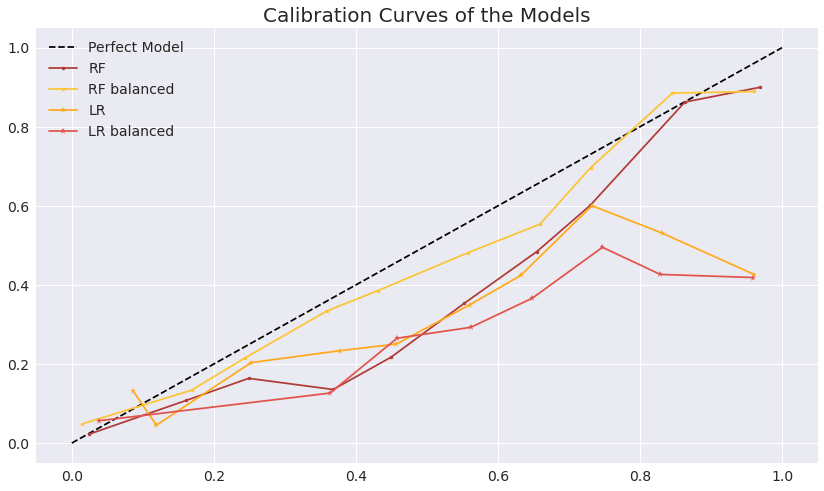

In [68]:
plt.figure(figsize=(14,8))
sns.set_palette('YlOrRd')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
# plot model reliability

plt.plot(rf_mpv, rf_fop, marker='.', color='#B03B37')
plt.plot(rf_mpv_bal, rf_fop_bal, marker='.', color='#FDC534')
plt.plot(lasso_mpv, lasso_fop, marker='*', color='#FFAA1B')
plt.plot(lasso_mpv_bal, lasso_fop_bal, marker='*', color='#E2544B')
plt.legend(['Perfect Model','RF','RF balanced','LR','LR balanced'], fontsize=14)
plt.title('Calibration Curves of the Models', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()